In [1]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

In [2]:
import sys
if IN_COLAB:
    !git clone -q https://github.com/lukaslaobeyer/token-opt.git
    !pip install -q --progress-bar off jaxtyping open_clip_torch omegaconf
    sys.path.insert(0, "token-opt")
else:
    sys.path.insert(0, "..")

In [3]:
import os
# Set this environment for deterministic execution
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"

In [4]:
import torch
# Enable for deterministic algorithms
torch.use_deterministic_algorithms(True, warn_only=False)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

from pathlib import Path
import numpy as np
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.v2 as v2
import torchvision.transforms.v2.functional as tvf
from torchvision.datasets import ImageNet
from einops import rearrange

In [5]:
from tto.test_time_opt import (
    TestTimeOpt,
    TestTimeOptConfig,
)

In [6]:
device = torch.device("cuda")

## Utils

In [7]:
def load_img(path, device=None):
    if IN_COLAB:
        path = "./token-opt/notebooks" / Path(path)
    img = (1. / 255.) * torch.from_numpy(
        np.array(Image.open(path)).astype(np.float32)
    ).permute(2, 0, 1)
    img = tvf.resize(img, 256)
    img = tvf.center_crop(img, 256)
    img = img.unsqueeze(0)
    if device is not None:
        img = img.to(device)
    return img

def display_image(*tensors):
    tensors = [255. * t.squeeze() for t in tensors]
    img = Image.fromarray(rearrange(
        tensors, "b c h w -> h (b w) c"
    ).to("cpu", dtype=torch.uint8).numpy())
    display(img)

class InpaintingPlotter:
    def __init__(self, masked_img, mask):
        self.masked_img = masked_img
        self.mask = mask

    def __call__(self, info):
        if info.i % 50 == 0:
            print(f"i = {info.i}")
            img = tto.decode(info.tokens).clamp(0., 1.)
            img_blended = (1. - self.mask) * img + self.masked_img
            display_image(*img_blended)

In [8]:
def generate_mask(img, x0, y0, w, h):
  # 根据给定的矩形区域 (x0, y0, w, h)，生成一张与原图像 img 同形状的“遮罩”张量，矩形区域内为 0，其余区域为 1。
    N, _, H, W = img.shape
    xs = rearrange(torch.arange(W), "w -> () () () w")
    ys = rearrange(torch.arange(H), "h -> () () h ()")
    x1 = x0 + w
    y1 = y0 + h
    mask = torch.ones_like(img[:, :1, :, :])
    mask[(x0 < xs) & (xs < x1) & (y0 < ys) & (ys < y1)] = 0
    return mask.expand_as(img)

# Prepare masked image

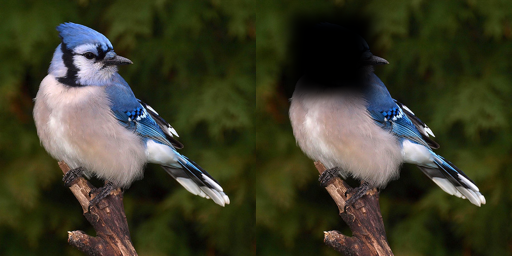

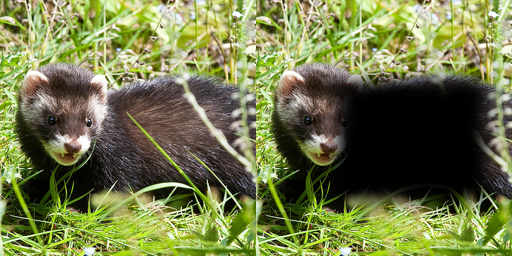

In [19]:
img = torch.cat((
    load_img("ILSVRC2012_val_00010240.png", device),
    load_img("ILSVRC2012_val_00008636.png", device),
), dim=0)
mask = torch.cat((
    generate_mask(img[:1], 30, 10, 90, 90),
    generate_mask(img[:1], 80, 80, 150, 120),
), dim=0)
mask = tvf.gaussian_blur(mask, 51)
mask = torch.clamp(mask, 0., 1.)
masked_img = mask * img
for i in range(mask.shape[0]):
    display_image(img[i], masked_img[i])

# Set up the objective function

In [11]:
class ReconstructionObjective:
    def __init__(self, masked_img, mask):
        self.masked_img = masked_img
        self.mask = mask
        self.sum_mask = torch.sum(self.mask, dim=[1, 2, 3])

    def __call__(self, img):
        return (1. / self.sum_mask) * torch.sum(
            torch.abs(self.masked_img - img) * self.mask,
            dim=[1, 2, 3],
        )


objective = ReconstructionObjective(masked_img, mask)

In [12]:
tto_config = TestTimeOptConfig(
    num_iter=351,
    ema_decay=0.98,
    lr=1e-1,
    enable_amp=True,
    reg_weight=2.5e-2,
    token_noise=5e-3,
    reg_type="zero",
)
tto = TestTimeOpt(tto_config, objective).to(device)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/2.56G [00:00<?, ?B/s]

# Run optimization

Input


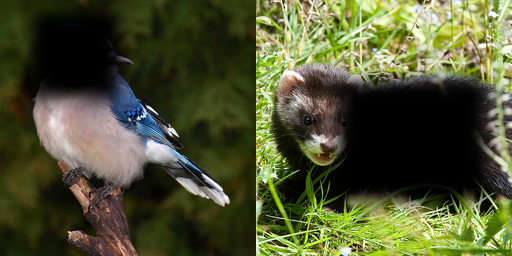

i = 0


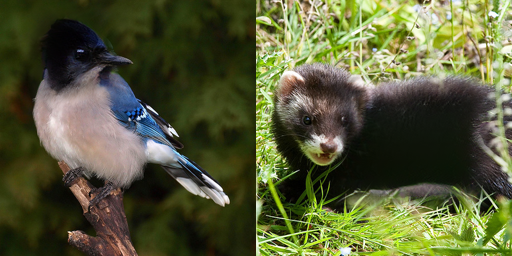

i = 50


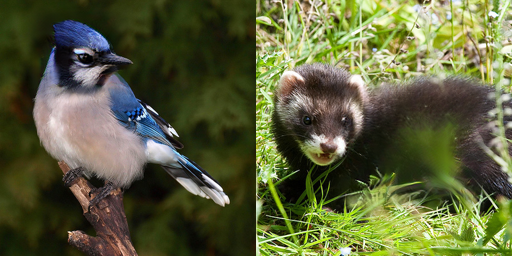

i = 100


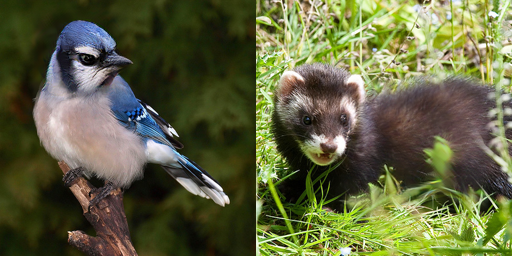

i = 150


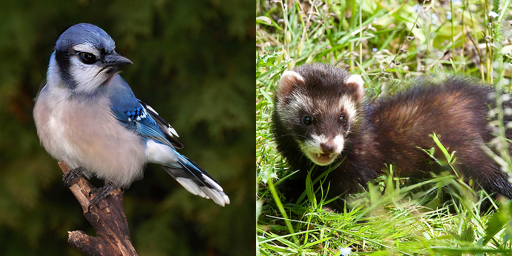

i = 200


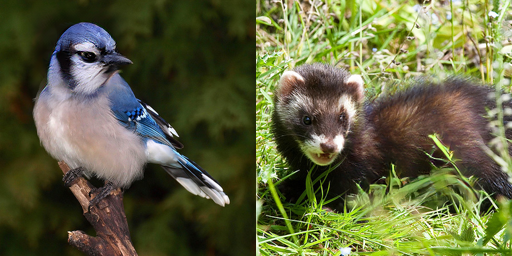

i = 250


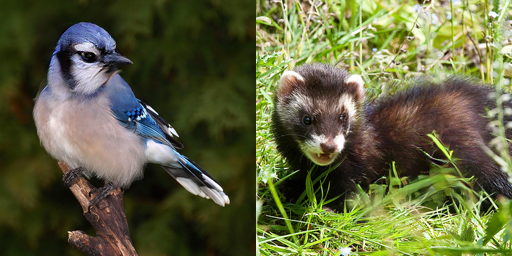

i = 300


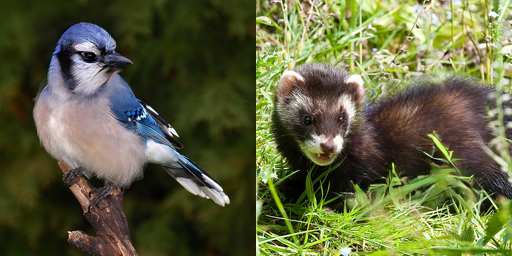

i = 350


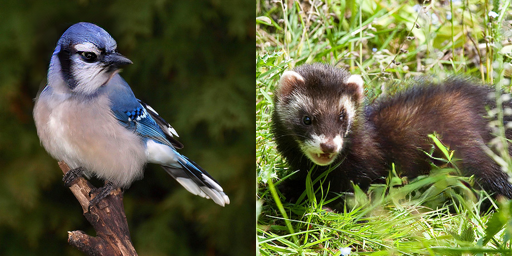

In [20]:
class TokenResetter:
    def __init__(self, titok, masked_img, mask, reset_period=5):
        self.titok = titok
        self.masked_img = masked_img
        self.mask = mask
        self.reset_period = reset_period

    @torch.no_grad()
    def __call__(self, info):
        if info.i % self.reset_period != 0:
            return
        dec_reset = (1. - self.mask) * info.img + self.masked_img
        return self.titok.encoder(dec_reset, self.titok.latent_tokens)


print("Input")
display_image(*masked_img)

# Run optimization
torch.manual_seed(42)
torch.cuda.manual_seed_all(0)
img_opt = tto(
    seed=masked_img,
    callback=InpaintingPlotter(masked_img, mask),
    token_reset_callback=TokenResetter(tto.titok, masked_img, mask)
  )